## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

RANDOM_STATE = 12345

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
# Дополнительно хронологически упорядочим индекс
data = data.sort_index()
print(data.index.is_monotonic)

True


In [4]:
# Выполним ресемплирование данных по одному часу
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


# 2. Анализ

В итоге мы имеем данные с начала марта по конец августа. Выполним следущий анализ данных на предмет сезонности и трендов:
* по месяцам
* по дням недели
* по часам за сутки

Данных по месяцам нам недостаточно, чтобы наверняка различить какую-то сезонность. Но мы можем распознать тренд, если он присутствует.

In [5]:
# Для дальнейшего анализа по выбранной периодичности добавим колонки
data['month'] = data.index.month
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

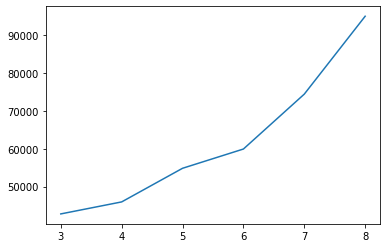

In [6]:
data_months = data.resample('1M').sum()
data_months['month'] = data_months.index.month
plt.plot(data_months['month'], data_months['num_orders'])

Да, с марта по август количество заказов значительно выросло. Правда достоверно понять только по данным датасэта, с чем это связано, не получится: возможно с ростом популярности службы такси, возможно в августе действительно заказов больше.

Перейдем к анализу количества заказов в течение недели и суток. Тут наверняка присутствует сезонность - ее и будем искать.

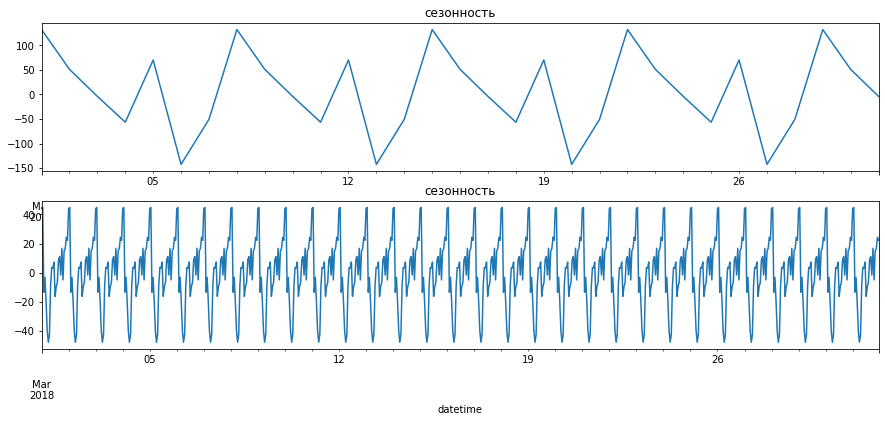

In [7]:
plt.figure(figsize=(15, 6))

# Сезонность внутри недели
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-31'].resample('1D').sum().loc[:, 'num_orders'])
plt.subplot(211)
plt.title('сезонность')
decomposed.seasonal.plot(ax=plt.gca())

# Сезонность внутри суток
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-31'].loc[:, 'num_orders'])
plt.subplot(212)
plt.title('сезонность')
decomposed.seasonal.plot(ax=plt.gca())

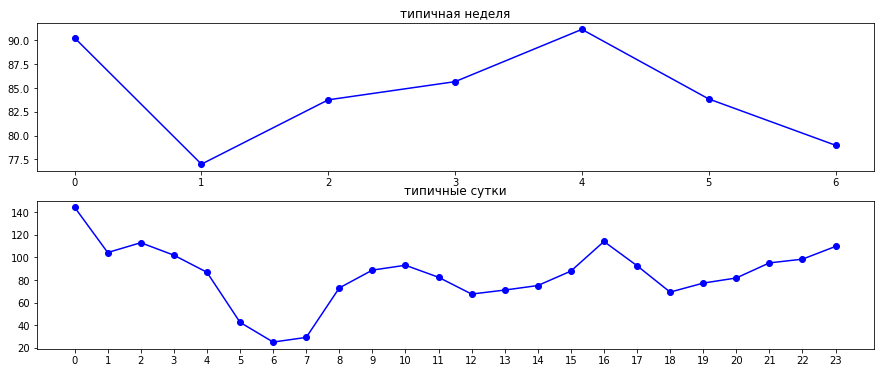

In [8]:
plt.figure(figsize=(15, 6))
plt.grid(False)

# Также построим график "типичных" недели и суток
typical_week = data.groupby('dayofweek')['num_orders'].mean()
plt.subplot(211)
plt.title('типичная неделя')
plt.xticks(range(0, 7, 1))
plt.plot(typical_week.index, typical_week.values, 'bo-')

typical_day = data.groupby('hour')['num_orders'].mean()
plt.subplot(212)
plt.title('типичные сутки')
plt.xticks(range(0, 24, 1))
plt.plot(typical_day.index, typical_day.values, 'bo-')

## Выводы:
* Мы увидили **рост числа заказов из месяца в месяц**, поиск причины возникновения тренда требует дополнительного исследования. Тренд также показывает, что временной ряд **не является стационарным** (т.к. матожидание количества заказов возрастает) - хотя, повторясь, этот тренд может оказаться всего лишь частью сезонности.
* **Внутри недели и внутри суток явно видна "сезонность"**
* Дополнительно для анализа сезонности мы построили графики типичной недели и типичных суток. На графиках присутствуют ожидаемые и очевидные закономерности (например, в пятницу такси заказывают чаще, чем во вторник; ранним утром такси пользуются реже через поздним вечером)

# 3. Обучение

In [9]:
def get_xy(data):
    x_data = data.drop('num_orders', axis=1)
    y_data = data['num_orders']
    return x_data, y_data

In [11]:
%%time

# Добавим скользящую для улучшения качества модели
model_LinearRegression = LinearRegression()
best_score = 10**6

for rolling in range(2, 7*24 + 1):
    rolled_data = data.copy()
    rolled_data['rolling'] = rolled_data['num_orders'].rolling(rolling).mean()
    rolled_data = rolled_data.dropna()

    x_data, y_data = get_xy(rolled_data)
    model_LinearRegression.fit(x_data, y_data)
    pred = model_LinearRegression.predict(x_data)
    rmse = mean_squared_error(y_data, pred) ** 0.5
    if rmse < best_score:
        print(f'{rolling}: {round(rmse, 10)}')
        best_score = rmse

2: 19.4237553174
CPU times: user 6.93 s, sys: 9.47 s, total: 16.4 s
Wall time: 16.4 s


In [12]:
# Используем полученную оптимальную скользящую
rolled_data = data.copy()
rolled_data['rolling'] = rolled_data['num_orders'].rolling(2).mean()
rolled_data = rolled_data.dropna()

train, test = train_test_split(rolled_data, test_size=0.2, shuffle=False)
x_train, y_train = get_xy(train)
x_test, y_test = get_xy(test)

## 3.1 Линейная регрессия

In [13]:
%%time

model_LinearRegression = LinearRegression()
model_LinearRegression.fit(x_train, y_train)
pred = model_LinearRegression.predict(x_train)
print(mean_squared_error(y_train, pred) ** 0.5)

17.16413708642319
CPU times: user 11.9 ms, sys: 3.36 ms, total: 15.2 ms
Wall time: 5.52 ms


## 3.2 Дерево решений

In [14]:
%%time

grid ={
    'n_estimators': range(300, 501, 100),
    'max_depth': range(10, 51, 10)
}

model_RandomForestRegressor = 0
best_score = 10**6

for n_estimators in grid['n_estimators']:
    for max_depth in grid['max_depth']:
        model = RandomForestRegressor(random_state=RANDOM_STATE,
                                     n_estimators=n_estimators,
                                     max_depth=max_depth)
        model.fit(x_train, y_train)
        pred = model.predict(x_train)
        rmse = mean_squared_error(y_train, pred) ** 0.5
        if rmse < best_score:
            best_score = rmse
            model_RandomForestRegressor = model
                   
print(model_RandomForestRegressor.get_params())
print(best_score)

{'bootstrap': True, 'criterion': 'mse', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}
5.6911067263945965
CPU times: user 45.7 s, sys: 81.7 ms, total: 45.8 s
Wall time: 46.6 s


## 3.3 Catboost

In [15]:
%%time

N_ITER = 5000

model_CatBoostRegressor = CatBoostRegressor(loss_function='RMSE', iterations=N_ITER)
model_CatBoostRegressor.fit(x_train, y_train, verbose=1000)
pred = model_CatBoostRegressor.predict(x_train)
rmse = mean_squared_error(y_train, pred) ** 0.5

0:	learn: 34.9817812	total: 49.5ms	remaining: 4m 7s
1000:	learn: 11.2909295	total: 23.9s	remaining: 1m 35s
2000:	learn: 9.9787811	total: 48s	remaining: 1m 11s
3000:	learn: 9.1126393	total: 1m 10s	remaining: 47.2s
4000:	learn: 8.4883402	total: 1m 34s	remaining: 23.7s
4999:	learn: 7.9783293	total: 1m 58s	remaining: 0us
CPU times: user 1min 44s, sys: 15.4 s, total: 2min
Wall time: 2min 5s


## Проверим результат обучения

In [16]:
pred = model_LinearRegression.predict(x_test)
rmse_LinearRegression = mean_squared_error(y_test, pred) ** 0.5

pred = model_RandomForestRegressor.predict(x_test)
rmse_RandomForestRegressor = mean_squared_error(y_test, pred) ** 0.5

pred = model_CatBoostRegressor.predict(x_test)
rmse_CatBoostRegressor = mean_squared_error(y_test, pred) ** 0.5

print('|{:<25}|{:<12}|'.format('Модель', 'RMSE'))
print('|{:<25}|{:>12}|'.format('LinearRegression', round(rmse_LinearRegression, 4)))
print('|{:<25}|{:>12}|'.format('RandomForestRegressor', round(rmse_RandomForestRegressor, 4)))
print('|{:<25}|{:>12}|'.format('CatBoostRegressor', round(rmse_CatBoostRegressor, 4)))

|Модель                   |RMSE        |
|LinearRegression         |     26.6097|
|RandomForestRegressor    |     30.8486|
|CatBoostRegressor        |     34.2101|


# 4. Тестирование

Проверим **горизонт планирования** у обученных модели. Для этого: 
* выборки будут выглядеть вот так: train - 80%, test1 - 10%, test2 - 10%, то есть train не меняется (поэтому заново учить модели не придется, а выборка test делится попалам)
* посчитаем и сравним rmse для test1 и test2

In [19]:
# Делим test выборку на 2 части попалам
test1, test2 = train_test_split(test, test_size=0.5, shuffle=False)
x_test1, y_test1 = get_xy(test1)
x_test2, y_test2 = get_xy(test2)

In [20]:
def get_horizon_forecast(model):
    pred = model.predict(x_train)
    rmse_train = mean_squared_error(y_train, pred) ** 0.5
    pred = model.predict(x_test1)
    rmse_test1 = mean_squared_error(y_test1, pred) ** 0.5
    pred = model.predict(x_test2)
    rmse_test2 = mean_squared_error(y_test2, pred) ** 0.5
    return rmse_train, rmse_test1, rmse_test2

In [21]:
print('|{:<25}|{:<12}|{:<12}|{:<12}|'.format('Модель', 'RMSE train', 'RMSE test1', 'RMSE test2'))

rmse_train, rmse_test1, rmse_test2 = get_horizon_forecast(model_LinearRegression)
print('|{:<25}|{:<12}|{:<12}|{:<12}|'.format('LinearRegression', round(rmse_train, 4), round(rmse_test1, 4), round(rmse_test2, 4)))

rmse_train, rmse_test1, rmse_test2 = get_horizon_forecast(model_RandomForestRegressor)
print('|{:<25}|{:<12}|{:<12}|{:<12}|'.format('RandomForestRegressor', round(rmse_train, 4), round(rmse_test1, 4), round(rmse_test2, 4)))

rmse_train, rmse_test1, rmse_test2 = get_horizon_forecast(model_CatBoostRegressor)
print('|{:<25}|{:<12}|{:<12}|{:<12}|'.format('CatBoostRegressor', round(rmse_train, 4), round(rmse_test1, 4), round(rmse_test2, 4)))

|Модель                   |RMSE train  |RMSE test1  |RMSE test2  |
|LinearRegression         |17.1641     |23.5773     |29.3244     |
|RandomForestRegressor    |5.6911      |23.9101     |36.479      |
|CatBoostRegressor        |7.9783      |24.2982     |41.8204     |


### Вывод
* Мы получили требуемую точность (не больше 48) **(ну теперь уже я сомневаюсь?)**
* **Горизонт планирования** у наши моделей невелик - для стратегических гипотез они не подойдут, только для оперативных предсказаний:
<img src='https://avatars.mds.yandex.net/get-zen_doc/177006/pub_5b0acc90581669f4cf267898_5b0acce87ddde8576ef0f5ab/scale_1200' width=70%>